In [42]:
import sqlalchemy
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
Base= automap_base()
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np


In [43]:
database_path='hawaii.sqlite'
engine=create_engine(f'sqlite:///{database_path}')
conn= engine.connect()

In [44]:
Base.prepare(engine, reflect= True)
Base.classes.keys()

['measurement', 'station']

In [45]:
Measurement= Base.classes.measurement
Station= Base.classes.station

In [48]:
session= Session(engine)


In [49]:
# Precipitation Analysis
twelve_month_ago = dt.date(2017,8,23) - relativedelta(months=+12)
now= dt.date(2017,8,23)
prcp_12=session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date <=now).\
        filter(Measurement.date >= twelve_month_ago).all()
df_prcp_12=pd.DataFrame(prcp_12, columns=['date','prcp'])
df_prcp_12_clean=df_prcp_12.dropna()
df_prcp_12_clean.set_index('date', inplace= True)
df_prcp_12_clean=df_prcp_12_clean.sort_index()
df_prcp_12_clean

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


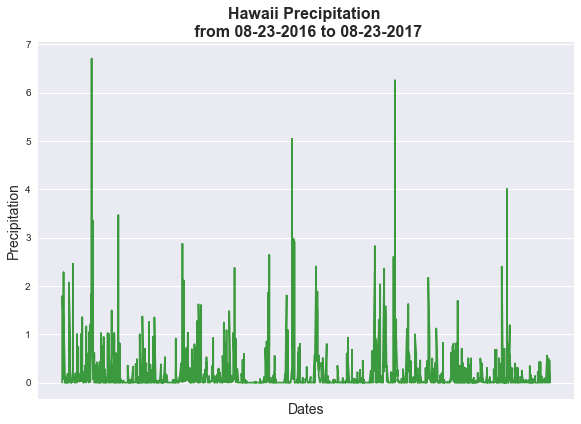

In [51]:
# Precipitation plot for last year
style.use('seaborn')
plt.plot(df_prcp_12_clean, color='green', alpha=0.75)
plt.tight_layout()
plt.xlabel("Dates",fontsize=14)
plt.ylabel("Precipitation",fontsize=14)
plt.title("Hawaii Precipitation \n from 08-23-2016 to 08-23-2017", fontsize=16, fontweight="bold")
plt.xticks([], [])
plt.savefig('precipitationOneYear.png')
plt.show()

In [52]:
stastistic_nums= df_prcp_12_clean.describe()
stastistic_nums

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [53]:
# Station Analysis
# Total numbers of stations
session.query(func.count(Station.station)).all()

[(9)]

In [54]:
# Most active stations
## List the stations and observation counts in descending order
station_counts=[Station.station, func.count(Measurement.tobs)]
obser_count=session.query(*station_counts).\
    filter(Station.station==Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
obser_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [55]:
## Most active stations
most_active=session.query(*station_counts).\
    filter(Station.station==Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).\
    limit(1).all()
most_active_unzip = list(np.ravel(most_active))
most_active_unzip

['USC00519281', '2772']

In [56]:
# Least active stations
## List the stations and observation counts in descending order
obser_count_asc=session.query(*station_counts).\
    filter(Station.station==Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs)).all()
obser_count_asc

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [57]:
## Least active stations
least_active= session.query(*station_counts).\
    filter(Station.station==Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs)).\
    limit(1).all()
least_active_unzip = list(np.ravel(least_active))
least_active_unzip

['USC00518838', '511']

In [58]:
# 12 month temperatures in the most active station
temp_12=session.query(Measurement.date, Measurement.tobs).\
    filter(Station.station==Measurement.station).\
    filter(Station.station==most_active_unzip[0]).\
    filter(Measurement.date <=now).\
    filter(Measurement.date >= twelve_month_ago).all()
df_temp_12=pd.DataFrame(temp_12, columns=['date','temp'])
df_temp_12_clean=df_temp_12.dropna()
df_temp_12_clean

,date,temp
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


In [59]:
# Min, max, avg temperatures for the most active stations
sel=[func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_data=session.query(*sel).\
    filter(Station.station==Measurement.station).\
    group_by(Measurement.station).filter(Station.station==most_active_unzip[0]).all()
most_active_data

[(54.0, 85.0, 71.66378066378067)]

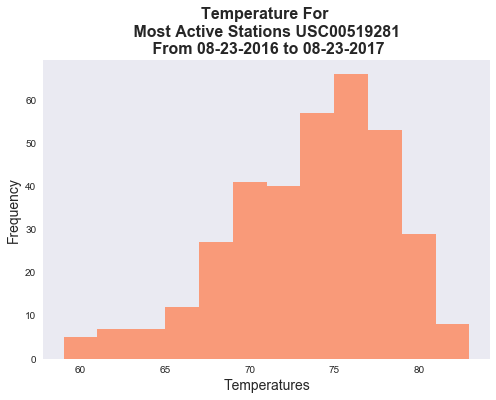

In [60]:
# Plot last 12 months of temperature histogram
plt.hist(df_temp_12_clean['temp'], bins=12, color= 'coral', alpha=0.75)
plt.xlabel('Temperatures',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title(f'Temperature For \n Most Active Stations {most_active_unzip[0]} \n From 08-23-2016 to 08-23-2017',fontsize=16,fontweight="bold")
plt.savefig('mostActive_Temp.png')
plt.grid()
plt.show()